# Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np

import scipy
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from sklearn import metrics
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## Reading the Data

In [2]:
data = pd.read_excel('Quickfreightdata.xlsx')

In [3]:
df = data.copy()

## Data Exploration & Preprocessing

In [4]:
df.shape

(18739, 13)

*The data contains 13 features and 18739 records.*

*Getting an idea of the kind of values stored in each variable by looking at the first 5 records*

In [5]:
df.head()

ORDER_NBR EQUIPMENT_TYPE  CUSTOMER_MILES  WEIGHT  ORDER_COST  \
0   535361133     53 FLATBED             802   42000        0.00   
1  1499443993              V               0   40500      875.00   
2  1058279607            NaN             774       0       88.14   
3  2093496262              V               0   40500      875.00   
4  2373724838              V               0   40500      875.00   

  FIRST_PICK_ZIP FIRST_PICK_EARLY_APPT FIRST_PICK_LATE_APPT LAST_DELIVERY_ZIP  \
0          21224   2015-07-13 07:30:00  2015-07-13 15:00:00             62707   
1        L1W 3H9   2015-07-06 14:00:00  2015-07-06 14:00:00             13619   
2          46037   2015-07-01 08:00:00  2015-07-02 17:00:00             73107   
3        L1W 3H9   2015-07-07 14:00:00  2015-07-07 14:00:00             13619   
4        L1W 3H9   2015-07-08 14:00:00  2015-07-08 14:00:00             13619   

  LAST_DELIVERY_EARLY_APPT LAST_DELIVERY_LATE_APPT IS_HAZARDOUS  \
0      2015-07-14 08:00:00     2015-07-14 16:00:00            N   
1      2015-07-07 07:00:00     2015-07-07 16:00:00            N   
2      2015-07-07 08:00:00     2015-07-07 17:00:00            N   
3      2015-07-08 07:00:00     2015-07-08 16:00:00            N   
4      2015-07-09 07:00:00     2015-07-09 16:00:00            N   

         CREATED_DATE  
0 2015-07-01 10:22:00  
1 2015-07-02 10:37:00  
2 2015-07-01 15:05:00  
3 2015-07-02 10:38:00  
4 2015-07-02 11:16:00

In [6]:
df.duplicated().sum()

0

*The data has no duplicates.*

*The ORDER_NBR column seems to unique for each record, which would make it insignificant for our analysis, hence confirming the same* 

In [7]:
len(df['ORDER_NBR'].unique())

18739

*Dropping features that are either all unique or involve dates and times, since that isn't useful for our analysis in this case.*

In [8]:
df.drop(['ORDER_NBR', 'FIRST_PICK_EARLY_APPT', 'FIRST_PICK_LATE_APPT', 'LAST_DELIVERY_EARLY_APPT', 'LAST_DELIVERY_LATE_APPT', 'CREATED_DATE'], axis = 1, inplace = True)

*Checking for null values*

In [9]:
df.isna().sum()

EQUIPMENT_TYPE       1011
CUSTOMER_MILES          0
WEIGHT                  0
ORDER_COST              6
FIRST_PICK_ZIP          0
LAST_DELIVERY_ZIP       0
IS_HAZARDOUS            0
dtype: int64

*Dropping null values of the target column, since there are just a few*

In [10]:
df = df[~df['ORDER_COST'].isna()]

*A glance at the available variables and their properties*

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18733 entries, 0 to 18738
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   EQUIPMENT_TYPE     17727 non-null  object 
 1   CUSTOMER_MILES     18733 non-null  int64  
 2   WEIGHT             18733 non-null  int64  
 3   ORDER_COST         18733 non-null  float64
 4   FIRST_PICK_ZIP     18733 non-null  object 
 5   LAST_DELIVERY_ZIP  18733 non-null  object 
 6   IS_HAZARDOUS       18733 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 1.1+ MB


*Separating numerical and categorical variables for further analysis*

In [12]:
num_cols = [col for col in df.columns if df[col].dtype == 'int64' or df[col].dtype == 'float64']
df[['FIRST_PICK_ZIP', 'LAST_DELIVERY_ZIP', 'IS_HAZARDOUS']] = df[['FIRST_PICK_ZIP', 'LAST_DELIVERY_ZIP', 'IS_HAZARDOUS']].astype('category')

*Basic statistics for a better understanding of the numerical columns*

In [13]:
df.describe()

CUSTOMER_MILES         WEIGHT    ORDER_COST
count    18733.000000   18733.000000  18733.000000
mean       588.230129   25219.295254    954.230941
std        512.017845   16310.085569    938.818390
min          0.000000       0.000000      0.000000
25%        254.000000    8000.000000    400.000000
50%        436.000000   28192.000000    700.000000
75%        716.000000   42000.000000   1300.000000
max       3733.000000  300000.000000   8000.000000

*Looking at the relationships of the numerical variables with the target column - ORDER_COST*

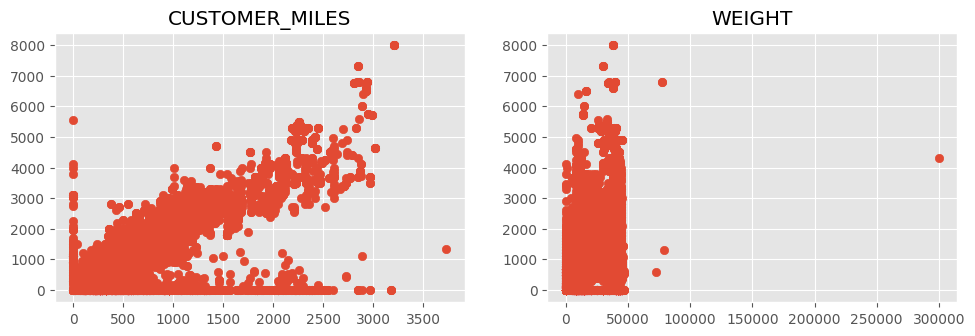

In [14]:
plt.figure(figsize = (18, 3.5))
for index, col in enumerate(num_cols):
    if col != 'ORDER_COST':
        ax = plt.subplot(1, 3, index + 1)
        ax.scatter(x = df[col], y = df['ORDER_COST'])
        ax.set_title(col)

*The above plots show certain points deviate from the general trend. However, they can be easily removed as such points are low in number and dropping them would not affect our data significantly.*

In [15]:
#len(df[df['CUSTOMER_MILES'] >= 2500])
df = df[df['CUSTOMER_MILES'] < 2500]

#len(df[df['WEIGHT'] >= 50000])
df = df[df['WEIGHT'] < 50000]

In [16]:
len(df[df['WEIGHT'] == 0]) + len(df[df['ORDER_COST'] == 0]) + len(df[df['CUSTOMER_MILES'] == 0])

4909

*The above exploration showed that the data contains zeroes. However, they cannot be dropped since they make up about a quarter of the data, hence we must check if they are meaningful, for further analysis.*

*Filtering out the records where CUSTOMER_MILES, WEIGHT and ORDER_COST are all zero.* 

In [17]:
df = df.loc[~((df['CUSTOMER_MILES'] == 0) & (df['WEIGHT'] == 0) & (df['ORDER_COST'] == 0))]

*Imputing the zero values in the WEIGHT column with mean, as practically, no package can be weightless.*

In [18]:
df.loc[df['WEIGHT'] == 0, 'WEIGHT'] = df['WEIGHT'].mean()

In [19]:
df[df['CUSTOMER_MILES'] == 0]

EQUIPMENT_TYPE  CUSTOMER_MILES   WEIGHT  ORDER_COST FIRST_PICK_ZIP  \
1                  V               0  40500.0       875.0        L1W 3H9   
3                  V               0  40500.0       875.0        L1W 3H9   
4                  V               0  40500.0       875.0        L1W 3H9   
5                  V               0  40500.0      1050.0        L1W 3H9   
106                V               0  25000.0         0.0          91761   
...              ...             ...      ...         ...            ...   
18327              V               0  23000.0      3050.0          84721   
18328              V               0  23000.0      3050.0          84721   
18359              V               0  40500.0      1050.0        L1W 3H9   
18420              V               0  30000.0      1500.0          29330   
18490              V               0  23000.0      3050.0          84721   

      LAST_DELIVERY_ZIP IS_HAZARDOUS  
1                 13619            N  
3                 13619            N  
4                 13619            N  
5                 21532            N  
106               78045            N  
...                 ...          ...  
18327            V4W3Z1            N  
18328           V3R 7A2            N  
18359             21740            N  
18420            N1H6H9            N  
18490            V4W3Z1            N  

[206 rows x 7 columns]

*A little manual exploration showed that for certain zip codes, particularly the alphanumeric ones, always had CUSTOMER_MILES = 0. We exclude such records from our analysis since those are suggestive of internal shipment transfer in the company. In other words, such zeroes are meaningful and must not be modified.*

In [20]:
non_num_or = set([i for i in df['FIRST_PICK_ZIP'] if type(i) == str])
alpha_num_or = set([j for j in non_num_or if '-' not in j])

non_num_dest = set([i for i in df['LAST_DELIVERY_ZIP'] if type(i) == str])
alpha_num_dest = set([j for j in non_num_dest if '-' not in j])

cond1 = df['FIRST_PICK_ZIP'].isin(alpha_num_or)
cond2 = df['LAST_DELIVERY_ZIP'].isin(alpha_num_dest)

COND1 = (cond1 | cond2)
COND2 = (df['CUSTOMER_MILES'] == 0)
df = df[~(COND1 & COND2)]

*Imputing rest of the zeroes in CUSTOMER_MILES with the median values*

In [21]:
df.loc[df['CUSTOMER_MILES'] == 0, 'CUSTOMER_MILES'] = df['CUSTOMER_MILES'].median()

**Treating the zeroes in the target variable :**

In [22]:
unit_cost = (df['ORDER_COST'].mean())/((df['CUSTOMER_MILES'].mean())*(df['WEIGHT'].mean()))

def cost_impute(row):
    return unit_cost * row['CUSTOMER_MILES'] * row['WEIGHT']

In [23]:
cost_0 = (df['ORDER_COST'] == 0)
df.loc[cost_0, 'ORDER_COST'] = df.apply(cost_impute, axis = 1)

In [24]:
df.loc[df['EQUIPMENT_TYPE'].isna(), 'EQUIPMENT_TYPE'] = df['EQUIPMENT_TYPE'].mode()[0]

**Checking the distribution of the numerical columns:**

In [25]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

fig = make_subplots(rows = 1, cols = 3)

# Create data for subplot 1
cost = go.Box(y = df['ORDER_COST'], name = 'ORDER_COST')

# Create data for subplot 2
miles = go.Box(y = df['CUSTOMER_MILES'], name = 'CUSTOMER_MILES')

# Create data for subplot 3
weight = go.Box(y = df['WEIGHT'], name = 'WEIGHT')

# Add each trace to the appropriate subplot
fig.add_trace(cost, row = 1, col = 1)
fig.add_trace(miles, row = 1, col = 2)
fig.add_trace(weight, row = 1, col = 3)

fig.update_layout(
    title = "Box Plots of Numerical Variables", 
    height = 500, 
    width = 1200,   
    showlegend = True
)

*The boxplots show that outlier treatment is required for ORDER_COST and CUSTOMER_MILES.*

**Treating outliers by replacing all extreme values with a threshold value**

In [26]:
CM_q1 = np.percentile(df['CUSTOMER_MILES'], 25)
CM_q3 = np.percentile(df['CUSTOMER_MILES'], 75)
CM_iqr = CM_q3 - CM_q1
CM_thresh = CM_q3 + (1.5*CM_iqr)
#CM_thresh = np.percentile(df['CUSTOMER_MILES'], 95)

OC_q1 = np.percentile(df['ORDER_COST'], 25)
OC_q3 = np.percentile(df['ORDER_COST'], 75)
OC_iqr = OC_q3 - OC_q1
OC_thresh = OC_q3 + (1.5*OC_iqr)
#OC_thresh = np.percentile(df['ORDER_COST'], 95)

CM_cond = df['CUSTOMER_MILES'] > CM_thresh
OC_cond = df['ORDER_COST'] > OC_thresh

df.loc[CM_cond, 'CUSTOMER_MILES'] = CM_thresh
df.loc[OC_cond, 'ORDER_COST'] = OC_thresh

**Binning the weight**

In [27]:
bin_size = 200
df['WeightRange'] = pd.cut(df['WEIGHT'], bins = range(0, int(df['WEIGHT'].max() + bin_size), bin_size), right = False)

In [28]:
df.head()

EQUIPMENT_TYPE  CUSTOMER_MILES        WEIGHT   ORDER_COST FIRST_PICK_ZIP  \
0     53 FLATBED           802.0  42000.000000  2020.612219          21224   
2              V           774.0  25210.011413    88.140000          46037   
6              R           560.0  43168.000000  1300.000000          64870   
7              R           560.0  42976.000000  1325.000000          64870   
8              R           560.0  42976.000000  1400.000000          64870   

  LAST_DELIVERY_ZIP IS_HAZARDOUS     WeightRange  
0             62707            N  [42000, 42200)  
2             73107            N  [25200, 25400)  
6             46176            N  [43000, 43200)  
7             46176            N  [42800, 43000)  
8             46176            N  [42800, 43000)

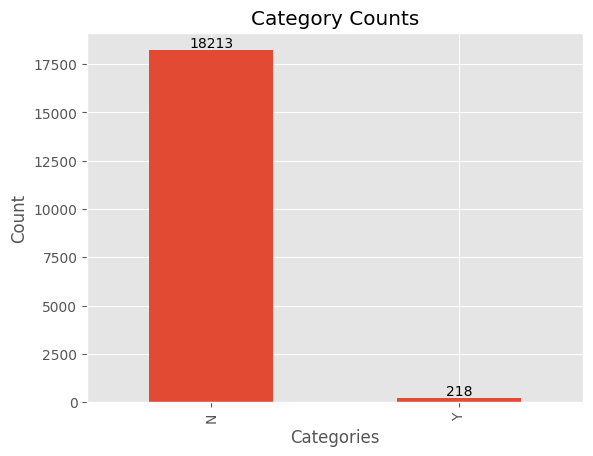

In [29]:
ax = df['IS_HAZARDOUS'].value_counts().plot(kind = 'bar')

# Adding labels
ax.set_xlabel('Categories')  # X-axis label
ax.set_ylabel('Count')       # Y-axis label
ax.set_title('Category Counts')  # Title of the plot

# Adding labels to the bars (optional)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

# Show the plot
plt.show()

*There are negligible records of shipments that are hazardous.*

## Q1. Distribution of Shipment Cost

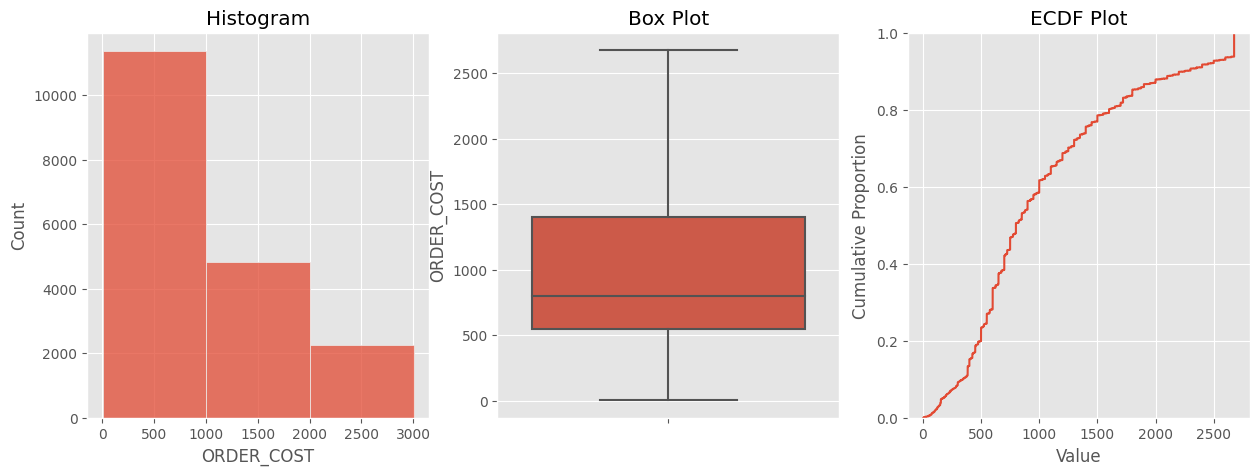

<Figure size 640x480 with 0 Axes>

In [30]:
# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the Histogram
sns.histplot(data = df, x = 'ORDER_COST', binwidth = 1000, ax = axes[0])
axes[0].set_title('Histogram')

# Plot the Box Plot
sns.boxplot(data = df, y = 'ORDER_COST', ax = axes[1])
axes[1].set_title('Box Plot')

# Plot the ECDF Plot
sns.ecdfplot(data = df, x = 'ORDER_COST', ax = axes[2])
axes[2].set_title('ECDF Plot')

plt.xlabel('Value')
plt.ylabel('Cumulative Proportion')
plt.title('ECDF Plot')
plt.show()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()

*The distribution is a bit skewed towards the right. However, in the boxplot, there are no outliers due to preprocessing.*

In [31]:
(len(df.loc[(df['ORDER_COST'] >= 1000) & (df['ORDER_COST'] <= 2000)])/len(df))*100

29.379849167164018

## Q2. Shipment Cost Vs Distance

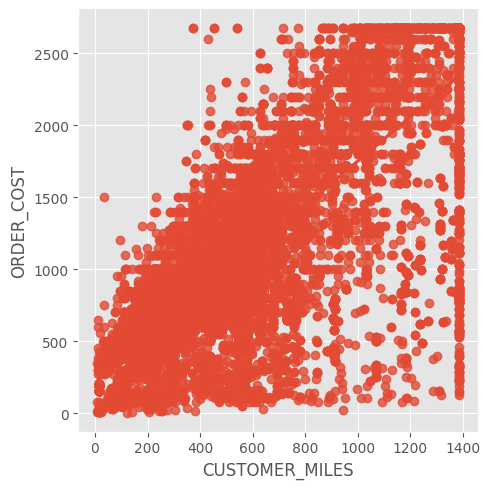

In [32]:
sns.lmplot(data = df, x = 'CUSTOMER_MILES', y = 'ORDER_COST')

*A very clear linear relationship is observed between CUSTOMER_MILES and ORDER_COST. They grow together, as is also reflected in the high positive correlation coefficient between them.*

In [33]:
df.corr()['ORDER_COST']['CUSTOMER_MILES']

C:\Users\kunja\AppData\Local\Temp\ipykernel_37116\3333737050.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



0.8103963244861929

## Q3. Weight as a predictor for Shipment Cost

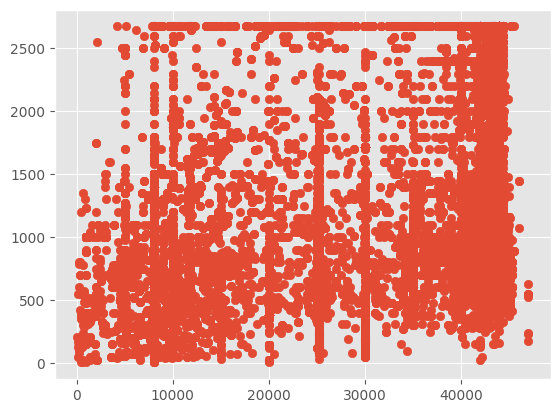

In [34]:
plt.scatter(df['WEIGHT'], df['ORDER_COST'])

*The data points are randomly scattered, signifying that WEIGHT is not an important predictor of ORDER_COST. The same is confirmed by the low correlation coefficient.*

In [35]:
df.corr(numeric_only = True).loc['WEIGHT', 'ORDER_COST']

0.32732330821845035

## Q4. Variance of Shipment cost with Origin and Destination

In [36]:
origin = df['FIRST_PICK_ZIP']
destn = df['LAST_DELIVERY_ZIP']

In [37]:
df['FIRST_PICK_ZIP'] = df['FIRST_PICK_ZIP'].cat.remove_unused_categories()
df['LAST_DELIVERY_ZIP'] = df['LAST_DELIVERY_ZIP'].cat.remove_unused_categories()

In [38]:
import scipy.stats as stats

groups = [group[1] for group in df.groupby(['FIRST_PICK_ZIP', 'LAST_DELIVERY_ZIP'])['ORDER_COST']]
F, p_value = stats.f_oneway(*groups)

alpha = 0.05  
if p_value < alpha:
    print("Reject the null hypothesis: There are significant differences among the groups.")
else:
    print("Fail to reject the null hypothesis: There are no significant differences among the groups.")

Reject the null hypothesis: There are significant differences among the groups.


## Q5. Shipment cost across hazardous and non hazardous items

In [39]:
# Cost based on hazard
haz = df.loc[df['IS_HAZARDOUS'] == 'N', 'ORDER_COST']
non_haz = df.loc[df['IS_HAZARDOUS'] == 'Y', 'ORDER_COST']

In [40]:
t_statistic, p_value, deg_freedom = sm.stats.ttest_ind(haz, non_haz, usevar = 'unequal')

print("T-statistic:", t_statistic)
print("P-value:", p_value)
print("Degrees of freedom:", deg_freedom)

alpha = 0.05

if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the two groups.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two groups.")

T-statistic: -0.4597966569311472
P-value: 0.6460979140852989
Degrees of freedom: 229.25973630166118
Fail to reject the null hypothesis: There is no significant difference between the two groups.


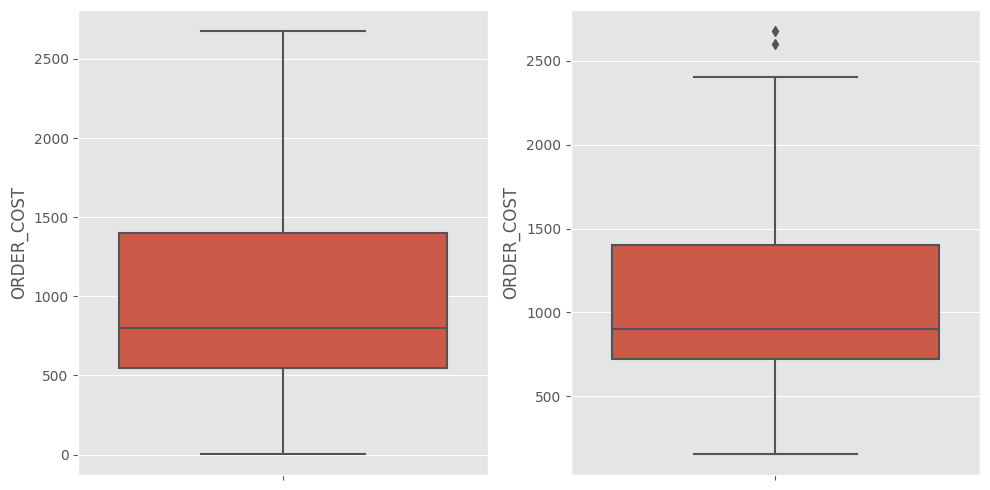

In [58]:
# group1 = df.loc[df['IS_HAZARDOUS'] == 'N', 'ORDER_COST']
# group2 = df.loc[df['IS_HAZARDOUS'] == 'Y', 'ORDER_COST']

fig, axes = plt.subplots(1, 2, figsize = (10, 5))
fig1 = sns.boxplot(y = haz, ax = axes[0])
fig2 = sns.boxplot(y = non_haz, ax = axes[1])

plt.tight_layout()

## Q6. Correlations

C:\Users\kunja\AppData\Local\Temp\ipykernel_37116\3237486771.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



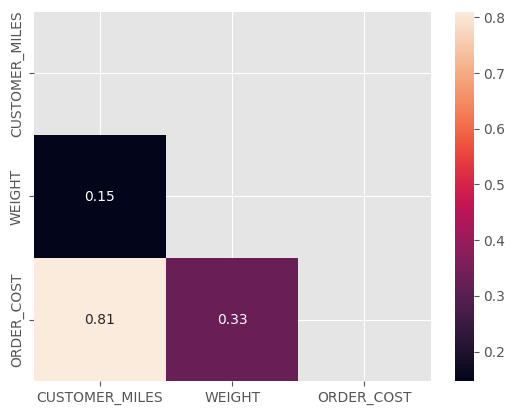

In [42]:
corr = df.corr()
mat = np.triu(corr)
sns.heatmap(corr, annot=True, mask = mat)
plt.show()

*The above correlation matrix shows that CUSTOMER_MILES has a strong correlation with the target variable, ORDER_COST.* 

## Q7. Covariances

C:\Users\kunja\AppData\Local\Temp\ipykernel_37116\3958984090.py:1: FutureWarning:

The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



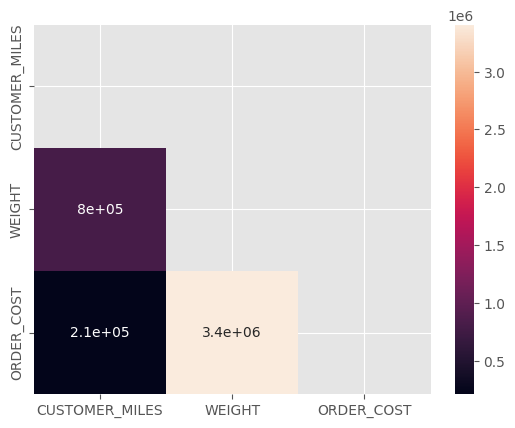

In [43]:
cov = df.cov()
mat = np.triu(cov)
sns.heatmap(cov, annot = True, mask = mat)
plt.show()

## Q8. ANOVA

In [44]:
import scipy.stats as stats

groups = [group[1] for group in df.groupby('FIRST_PICK_ZIP')['ORDER_COST']]
F, p_value = stats.f_oneway(*groups)

alpha = 0.05  
if p_value < alpha:
    print("Reject the null hypothesis: There are significant differences among the groups.")
else:
    print("Fail to reject the null hypothesis: There are no significant differences among the groups.")

Reject the null hypothesis: There are significant differences among the groups.


In [45]:
import scipy.stats as stats

groups = [group[1] for group in df.groupby('LAST_DELIVERY_ZIP')['ORDER_COST']]
F, p_value = stats.f_oneway(*groups)

alpha = 0.05  
if p_value < alpha:
    print("Reject the null hypothesis: There are significant differences among the groups.")
else:
    print("Fail to reject the null hypothesis: There are no significant differences among the groups.")

Reject the null hypothesis: There are significant differences among the groups.


In [46]:
import scipy.stats as stats

groups = [group[1] for group in df.groupby('IS_HAZARDOUS')['ORDER_COST']]
F, p_value = stats.f_oneway(*groups)

alpha = 0.05  
if p_value < alpha:
    print("Reject the null hypothesis: There are significant differences among the groups.")
else:
    print("Fail to reject the null hypothesis: There are no significant differences among the groups.")

Fail to reject the null hypothesis: There are no significant differences among the groups.


## Q9. Train - Test Split

In [47]:
X = df.drop(['ORDER_COST'], axis = 1)
y = df['ORDER_COST']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## Q10. Model Building

In [49]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
model1 = sm.OLS(y_train, X_train[['const', 'WEIGHT']])
results1 = model1.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:             ORDER_COST   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     1791.
Date:                Tue, 12 Sep 2023   Prob (F-statistic):               0.00
Time:                        09:40:08   Log-Likelihood:            -1.1668e+05
No. Observations:               14744   AIC:                         2.334e+05
Df Residuals:                   14742   BIC:                         2.334e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        624.4980     11.254     55.491      0.0

----------------------------------------------------------------------------------------------------------------------------------------------

In [50]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
model2 = sm.OLS(y_train, X_train[['const', 'CUSTOMER_MILES']])
results2 = model2.fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:             ORDER_COST   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                 2.779e+04
Date:                Tue, 12 Sep 2023   Prob (F-statistic):               0.00
Time:                        09:40:08   Log-Likelihood:            -1.0972e+05
No. Observations:               14744   AIC:                         2.194e+05
Df Residuals:                   14742   BIC:                         2.195e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            211.5708      6.026     35.

----------------------------------------------------------------------------------------------------------------------------------------------

In [51]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
model3 = sm.OLS(y_train, X_train[['const', 'WEIGHT', 'CUSTOMER_MILES']])
results3 = model3.fit()
print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:             ORDER_COST   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                 1.703e+04
Date:                Tue, 12 Sep 2023   Prob (F-statistic):               0.00
Time:                        09:40:08   Log-Likelihood:            -1.0870e+05
No. Observations:               14744   AIC:                         2.174e+05
Df Residuals:                   14741   BIC:                         2.174e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -26.0832      7.590     -3.

----------------------------------------------------------------------------------------------------------------------------------------------

In [52]:
from sklearn.preprocessing import LabelEncoder

In [53]:
le = LabelEncoder()
X_train['IS_HAZARDOUS'] = le.fit_transform(X_train['IS_HAZARDOUS'])
X_test['IS_HAZARDOUS'] = le.fit_transform(X_test['IS_HAZARDOUS'])

In [54]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
model4 = sm.OLS(y_train, X_train[['const', 'IS_HAZARDOUS']])
results4 = model4.fit()
print(results4.summary())

                            OLS Regression Results                            
Dep. Variable:             ORDER_COST   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.06541
Date:                Tue, 12 Sep 2023   Prob (F-statistic):              0.798
Time:                        09:40:08   Log-Likelihood:            -1.1753e+05
No. Observations:               14744   AIC:                         2.351e+05
Df Residuals:                   14742   BIC:                         2.351e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1040.9847      5.806    179.291   

**We get a low R^2 value which was expected from the ANOVA test conducted earlier. However, this column has been used for the sake of simplicity. Some more options could be to use FIRST_PICK_ZIP and LAST_PICK_ZIP (however there are a lot of categories) or experiment with EQUIPMENT_TYPE (with several NA values).**

In [55]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


scores = pd.DataFrame(columns = ['Model','MAE_Train','MSE_Train','RMSE_Train','MAPE_Train','MAE_Test','MSE_Test','RMSE_Test','MAPE_Test','R^2'])

#definition of error metrics function
def get_metrics(train_act,train_pred,test_act,test_pred,model_description,dataframe):
    MAE_Train = metrics.mean_absolute_error(train_act,train_pred)
    MSE_Train = metrics.mean_squared_error(train_act,train_pred)
    RMSE_Train = np.sqrt(metrics.mean_squared_error(train_act,train_pred))
    MAPE_Train = mean_absolute_percentage_error(train_act,train_pred)
    MAE_Test = metrics.mean_absolute_error(test_act,test_pred)
    MSE_Test = metrics.mean_squared_error(test_act,test_pred)
    RMSE_Test = np.sqrt(metrics.mean_squared_error(test_act,test_pred))
    MAPE_Test = mean_absolute_percentage_error(test_act,test_pred)
    R2 = metrics.r2_score(train_act,train_pred)
    s1 = pd.Series([model_description,MAE_Train,MSE_Train,RMSE_Train,MAPE_Train,MAE_Test,MSE_Test,RMSE_Test,MAPE_Test,R2],
                                           index=scores.columns)
    dataframe = dataframe.append(s1, ignore_index=True)
    return(dataframe)

In [56]:
scores = get_metrics(y_train, results1.predict(X_train[['const', 'WEIGHT']]), y_test, results1.predict(X_test[['const', 'WEIGHT']]), 'Weight_Simple_Linear_Regression', scores)
scores = get_metrics(y_train, results2.predict(X_train[['const', 'CUSTOMER_MILES']]), y_test, results2.predict(X_test[['const', 'CUSTOMER_MILES']]), 'CM_Simple_Linear_Regression', scores)
scores = get_metrics(y_train, results3.predict(X_train[['const', 'WEIGHT', 'CUSTOMER_MILES']]), y_test, results3.predict(X_test[['const', 'WEIGHT', 'CUSTOMER_MILES']]), 'Weight_Simple_Linear_Regression', scores)
scores = get_metrics(y_train, results4.predict(X_train[['const', 'IS_HAZARDOUS']]), y_test, results4.predict(X_test[['const', 'IS_HAZARDOUS']]), 'Cat_Simple_Linear_Regression', scores)
scores

C:\Users\kunja\AppData\Local\Temp\ipykernel_37116\2194493116.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\kunja\AppData\Local\Temp\ipykernel_37116\2194493116.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\kunja\AppData\Local\Temp\ipykernel_37116\2194493116.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\kunja\AppData\Local\Temp\ipykernel_37116\2194493116.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Model   MAE_Train      MSE_Train  RMSE_Train  \
0  Weight_Simple_Linear_Regression  525.109219  437971.778267  661.794363   
1      CM_Simple_Linear_Regression  290.458070  170232.313580  412.592188   
2  Weight_Simple_Linear_Regression  284.632873  148342.674189  385.152793   
3     Cat_Simple_Linear_Regression  563.735546  491168.355815  700.834043   

   MAPE_Train    MAE_Test       MSE_Test   RMSE_Test   MAPE_Test       R^2  
0  110.310517  537.093767  458974.936355  677.476890  109.633174  0.108310  
1   63.060515  287.903693  169058.667406  411.167444   63.143075  0.653415  
2   56.899922  279.914090  146540.831287  382.806519   55.901605  0.697981  
3  128.957676  574.278380  511480.616365  715.178730  128.794045  0.000004